# Conditionnal Generative Adversarial Network (CGAN)

In [28]:
import keras
from keras import layers
from keras.datasets import mnist
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = mnist.load_data()
nb_classes = 10

In [29]:
input_vector_size = 128
# Partie pour pouvoir générer un nombre spécifique
input = layers.Input(shape=(nb_classes,))
#x = layers.Embedding(10, 50)(input)
x = layers.Dense(49)(input)
x = layers.Reshape((7, 7, 1))(x)
# Partie pour générer aléatoirement un digit
input2 = layers.Input(shape=(input_vector_size,))
x2 = layers.Dense(1568)(input2)
x2 = layers.Reshape((7, 7, 32))(x2)
# Partie commune du générateur
x3 = layers.Concatenate()([x, x2])
x3 = layers.BatchNormalization()(x3)
x3 = layers.Conv2DTranspose(128, kernel_size=(3, 3), strides=2, padding="same", activation='relu')(x3)
x3 = layers.BatchNormalization()(x3)
x3 = layers.Conv2DTranspose(128, kernel_size=(3, 3), strides=2, padding="same", activation='relu')(x3)
x3 = layers.BatchNormalization()(x3)
x3 = layers.Conv2DTranspose(1, kernel_size=(3, 3), strides=1, padding="same", activation='relu')(x3)

generator = keras.Model([input, input2], x3)

generator.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 10)]         0           []                               
                                                                                                  
 input_20 (InputLayer)          [(None, 128)]        0           []                               
                                                                                                  
 dense_12 (Dense)               (None, 49)           539         ['input_19[0][0]']               
                                                                                                  
 dense_13 (Dense)               (None, 1568)         202272      ['input_20[0][0]']               
                                                                                            

In [30]:
# Partie permettant l'insertion de la condition, ici notre label
input = layers.Input(shape=(nb_classes,))
# x = layers.Embedding(10, 50)(input)
x = layers.Dense(28 * 28)(input)
x = layers.Reshape((28, 28, 1))(x)

# Partie pour discriminer une image
input2 = layers.Input(shape=(28, 28, 1))

x3 = layers.Concatenate()([x, input2])
x3 = layers.BatchNormalization()(x3)
x3 = layers.Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu')(x3)
x3 = layers.MaxPooling2D()(x3)
x3 = layers.BatchNormalization()(x3)
x3 = layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu')(x3)
x3 = layers.MaxPooling2D()(x3)
x3 = layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(x3)
x3 = layers.MaxPooling2D()(x3)
x3 = layers.Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu')(x3)
x3 = layers.MaxPooling2D()(x3)
x3 = layers.Flatten()(x3)
x3 = layers.Dense(1, activation='softmax')(x3)

discriminator = keras.Model([input, input2], x3)

discriminator.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 10)]         0           []                               
                                                                                                  
 dense_14 (Dense)               (None, 784)          8624        ['input_21[0][0]']               
                                                                                                  
 reshape_11 (Reshape)           (None, 28, 28, 1)    0           ['dense_14[0][0]']               
                                                                                                  
 input_22 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                           

In [31]:
generator.compile(loss="binary_crossentropy", optimizer='adam')
discriminator.compile(loss="binary_crossentropy", optimizer='adam')

In [32]:

input_class = layers.Input(shape=(nb_classes,))
input_noise = layers.Input(shape=(input_vector_size,))

discriminator.trainable = False
image = generator([input_class, input_noise])
valid = discriminator([input_class, image])

combined_network = keras.Model([input_class, input_noise], valid)
combined_network.summary()
combined_network.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])



Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 10)]         0           []                               
                                                                                                  
 input_24 (InputLayer)          [(None, 128)]        0           []                               
                                                                                                  
 model_9 (Functional)           (None, 28, 28, 1)    390848      ['input_23[0][0]',               
                                                                  'input_24[0][0]']               
                                                                                                  
 model_10 (Functional)          (None, 1)            108473      ['input_23[0][0]',        

In [33]:
def display_images():
    r, c = 5,2
    noise = np.random.normal(0, 1, (r * c, input_vector_size))
    random_y = []

    for i in range(r * c):
        random_y.append(i % nb_classes)

    random_y = vectorization(random_y)

    generated_images = generator.predict([np.array(random_y), noise])

    fig, axs = plt.subplots(r, c)
    count = 0
    y = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].set_title(str(y))
            axs[i, j].imshow(generated_images[count, :, :, ], cmap='gray')
            count += 1
            y = y + 1
            if y > 9:
                y = 0
    plt.show()
    plt.close()

In [38]:
def vectorization(y_label):
    res = []
    for item in y_label:
        y = np.zeros(nb_classes)
        y[item] = 1
        res.append(y)

    return np.array(res)

1/1 [==============================] - 0s 58ms/step
EPOCH ===  0
Generator loss =  [0.7019795179367065, 1.0]
Discriminator_loss =  0.17694157361984253
1/1 [==============================] - 0s 185ms/step


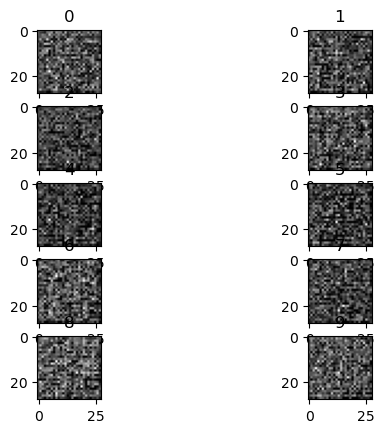

1/1 [==============================] - 0s 52ms/step
EPOCH ===  10
Generator loss =  [0.7371416091918945, 1.0]
Discriminator_loss =  0.15186180174350739
1/1 [==============================] - 0s 32ms/step


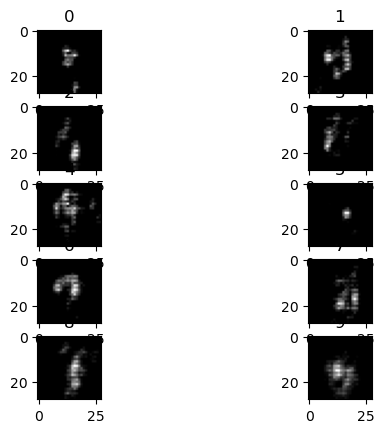

1/1 [==============================] - 0s 38ms/step
EPOCH ===  20
Generator loss =  [0.7773005962371826, 1.0]
Discriminator_loss =  0.11287762969732285
1/1 [==============================] - 0s 26ms/step


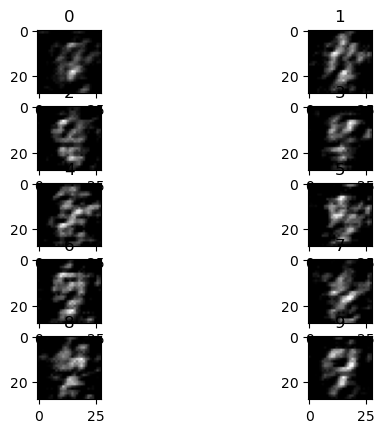

1/1 [==============================] - 0s 49ms/step
EPOCH ===  30
Generator loss =  [0.8032492399215698, 1.0]
Discriminator_loss =  0.11197289824485779
1/1 [==============================] - 0s 27ms/step


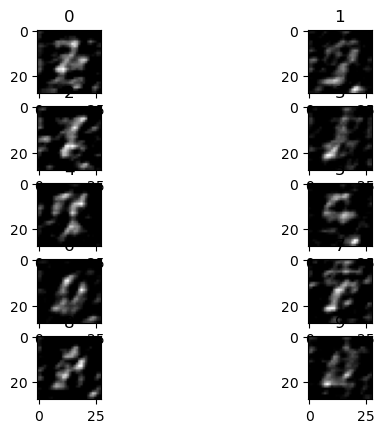

1/1 [==============================] - 0s 36ms/step
EPOCH ===  40
Generator loss =  [0.9859339594841003, 1.0]
Discriminator_loss =  0.04135507717728615
1/1 [==============================] - 0s 24ms/step


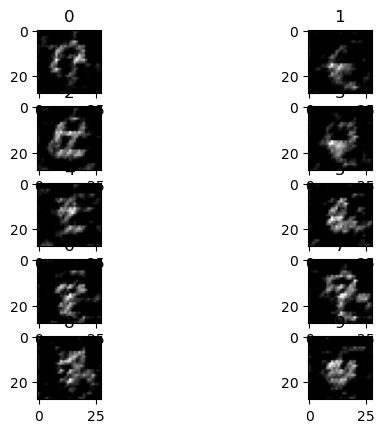

1/1 [==============================] - 0s 36ms/step
EPOCH ===  50
Generator loss =  [0.6317557096481323, 1.0]
Discriminator_loss =  0.048785433173179626
1/1 [==============================] - 0s 25ms/step


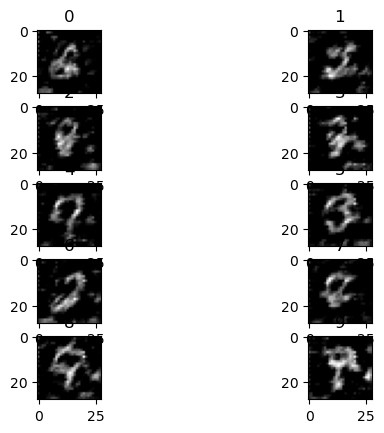

1/1 [==============================] - 0s 41ms/step
EPOCH ===  60
Generator loss =  [0.5622438192367554, 1.0]
Discriminator_loss =  0.012844633311033249
1/1 [==============================] - 0s 23ms/step


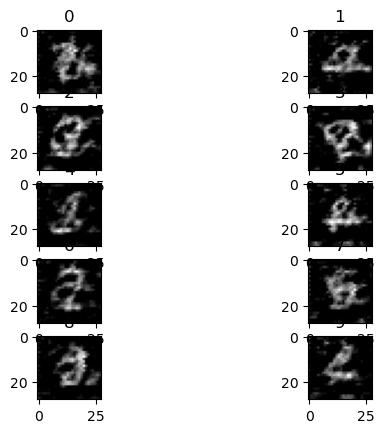

1/1 [==============================] - 0s 36ms/step
EPOCH ===  70
Generator loss =  [0.34945279359817505, 1.0]
Discriminator_loss =  0.15272551774978638
1/1 [==============================] - 0s 34ms/step


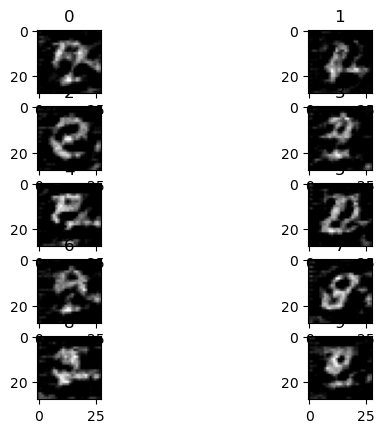

1/1 [==============================] - 0s 49ms/step
EPOCH ===  80
Generator loss =  [0.5121508836746216, 1.0]
Discriminator_loss =  0.043226584792137146
1/1 [==============================] - 0s 31ms/step


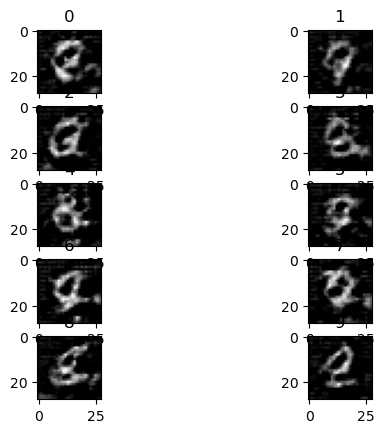

1/1 [==============================] - 0s 52ms/step
EPOCH ===  90
Generator loss =  [0.616523265838623, 1.0]
Discriminator_loss =  0.03933177515864372
1/1 [==============================] - 0s 42ms/step


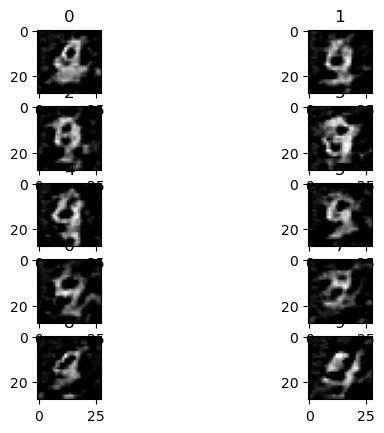

1/1 [==============================] - 0s 46ms/step
EPOCH ===  100
Generator loss =  [1.3260422945022583, 1.0]
Discriminator_loss =  0.0373547226190567
1/1 [==============================] - 0s 29ms/step


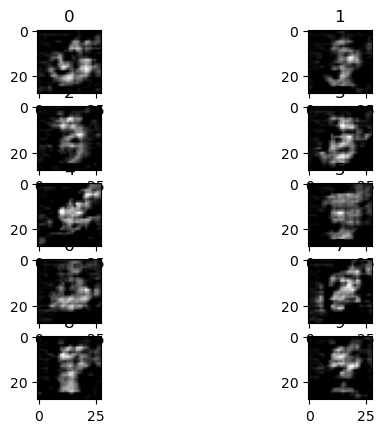

1/1 [==============================] - 0s 36ms/step
EPOCH ===  110
Generator loss =  [1.0262596607208252, 1.0]
Discriminator_loss =  0.04748819023370743
1/1 [==============================] - 0s 25ms/step


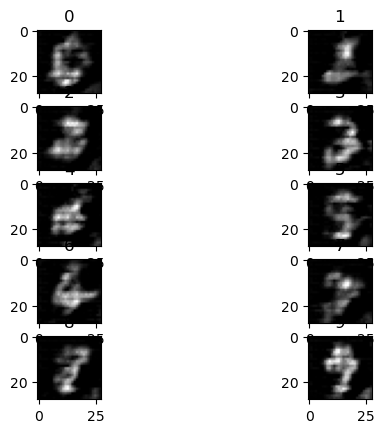

1/1 [==============================] - 0s 37ms/step
EPOCH ===  120
Generator loss =  [2.2505688667297363, 1.0]
Discriminator_loss =  0.03188502416014671
1/1 [==============================] - 0s 28ms/step


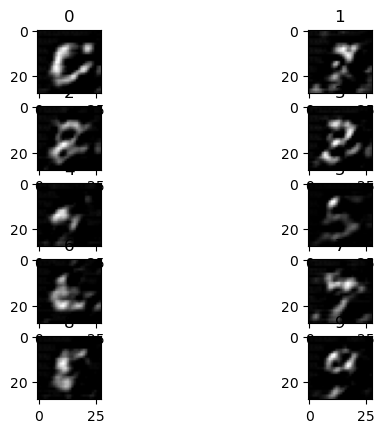

1/1 [==============================] - 0s 50ms/step
EPOCH ===  130
Generator loss =  [0.7417973279953003, 1.0]
Discriminator_loss =  0.04184079170227051
1/1 [==============================] - 0s 26ms/step


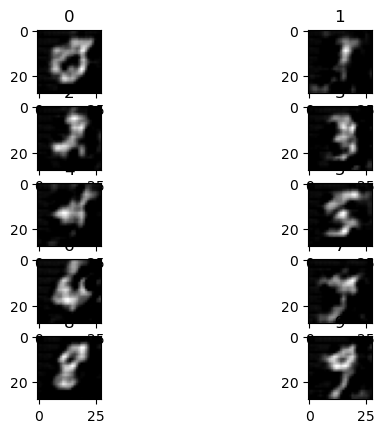

1/1 [==============================] - 0s 52ms/step
EPOCH ===  140
Generator loss =  [3.091764211654663, 1.0]
Discriminator_loss =  0.008358404040336609
1/1 [==============================] - 0s 34ms/step


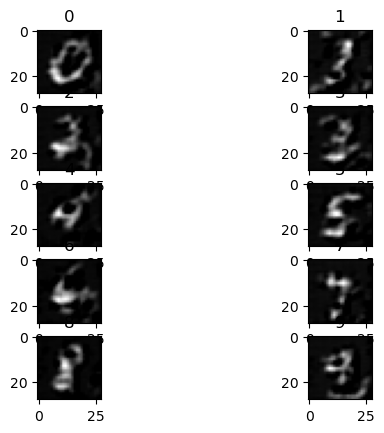

1/1 [==============================] - 0s 52ms/step
EPOCH ===  150
Generator loss =  [1.2434743642807007, 1.0]
Discriminator_loss =  0.05327088385820389
1/1 [==============================] - 0s 34ms/step


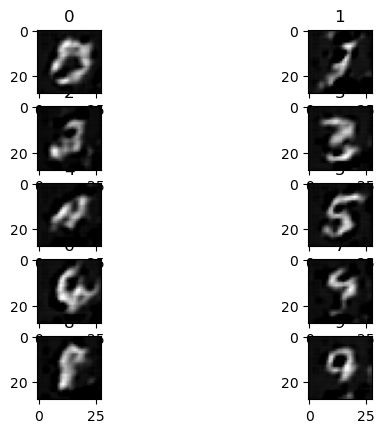

1/1 [==============================] - 0s 42ms/step
EPOCH ===  160
Generator loss =  [0.5864236950874329, 1.0]
Discriminator_loss =  0.017565209418535233
1/1 [==============================] - 0s 29ms/step


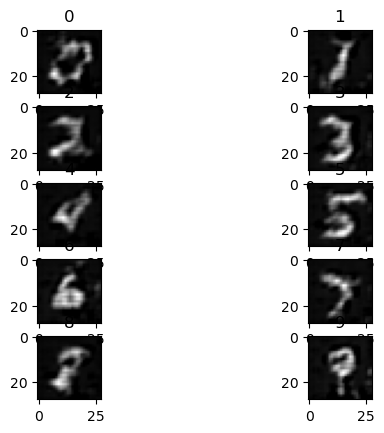

1/1 [==============================] - 0s 63ms/step
EPOCH ===  170
Generator loss =  [1.206714153289795, 1.0]
Discriminator_loss =  0.015838123857975006
1/1 [==============================] - 0s 48ms/step


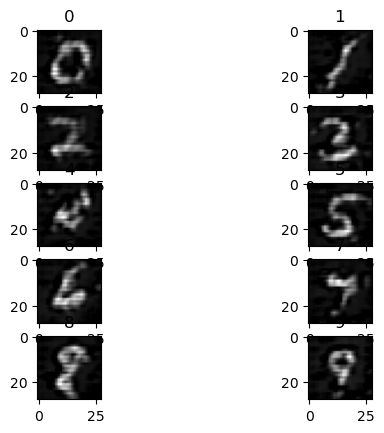

1/1 [==============================] - 0s 57ms/step
EPOCH ===  180
Generator loss =  [0.3175402879714966, 1.0]
Discriminator_loss =  0.02960941754281521
1/1 [==============================] - 0s 40ms/step


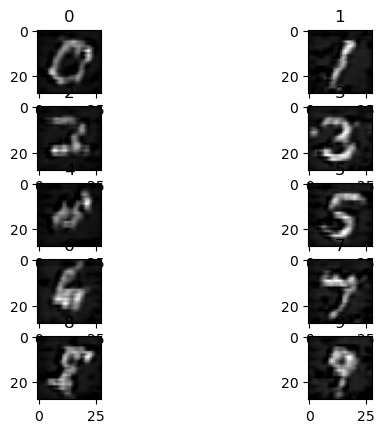

1/1 [==============================] - 0s 45ms/step
EPOCH ===  190
Generator loss =  [0.2615240812301636, 1.0]
Discriminator_loss =  0.011393621563911438
1/1 [==============================] - 0s 43ms/step


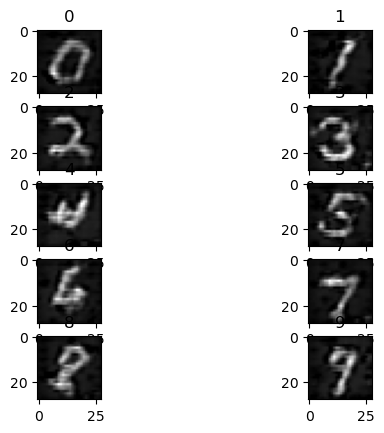

1/1 [==============================] - 0s 38ms/step
EPOCH ===  200
Generator loss =  [0.08529435098171234, 1.0]
Discriminator_loss =  0.006958287674933672
1/1 [==============================] - 0s 30ms/step


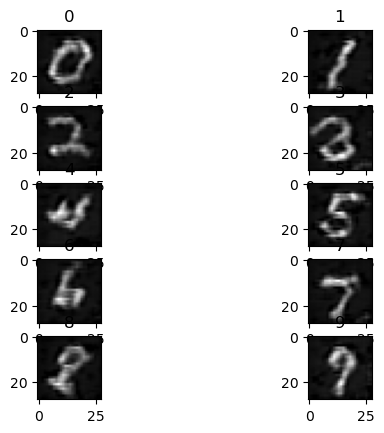

1/1 [==============================] - 0s 50ms/step
EPOCH ===  210
Generator loss =  [0.05302615091204643, 1.0]
Discriminator_loss =  0.010029185563325882
1/1 [==============================] - 0s 92ms/step


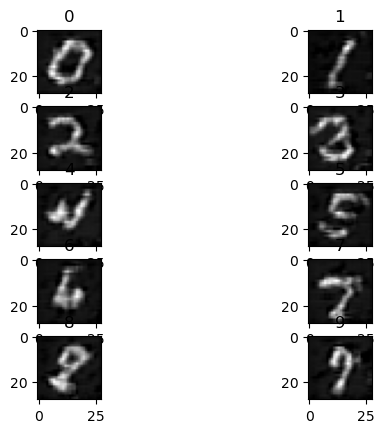

1/1 [==============================] - 0s 50ms/step
EPOCH ===  220
Generator loss =  [1.4296040534973145, 1.0]
Discriminator_loss =  0.0019558765925467014
1/1 [==============================] - 0s 29ms/step


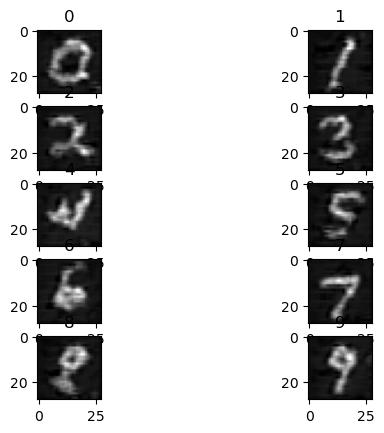

1/1 [==============================] - 0s 40ms/step
EPOCH ===  230
Generator loss =  [0.12472546845674515, 1.0]
Discriminator_loss =  0.012937473133206367
1/1 [==============================] - 0s 31ms/step


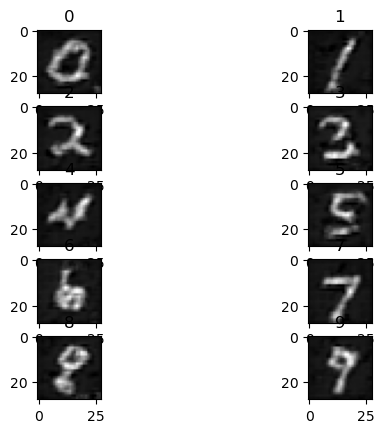

1/1 [==============================] - 0s 68ms/step
EPOCH ===  240
Generator loss =  [0.13602903485298157, 1.0]
Discriminator_loss =  0.0035233558155596256
1/1 [==============================] - 0s 30ms/step


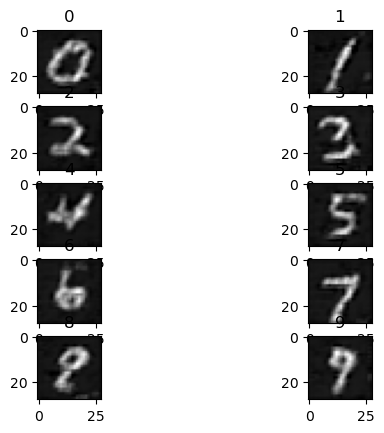

1/1 [==============================] - 0s 60ms/step
EPOCH ===  250
Generator loss =  [0.4915234446525574, 1.0]
Discriminator_loss =  0.0054823365062475204
1/1 [==============================] - 0s 46ms/step


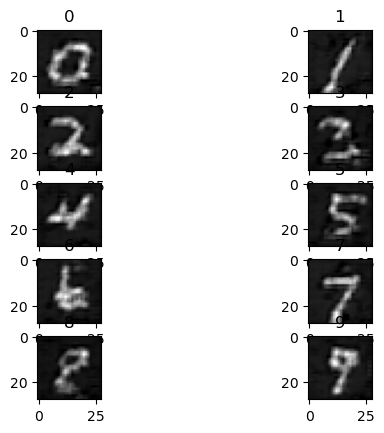

1/1 [==============================] - 0s 37ms/step
EPOCH ===  260
Generator loss =  [0.17779187858104706, 1.0]
Discriminator_loss =  0.0010899058543145657
1/1 [==============================] - 0s 47ms/step


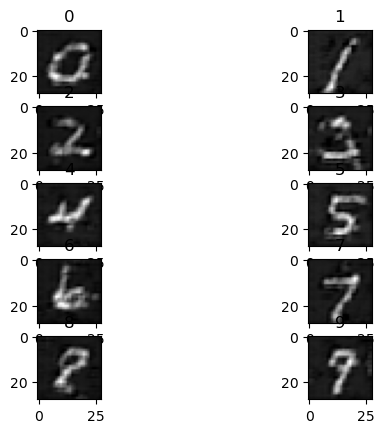

1/1 [==============================] - 0s 38ms/step
EPOCH ===  270
Generator loss =  [0.02892616018652916, 1.0]
Discriminator_loss =  0.003594568930566311
1/1 [==============================] - 0s 27ms/step


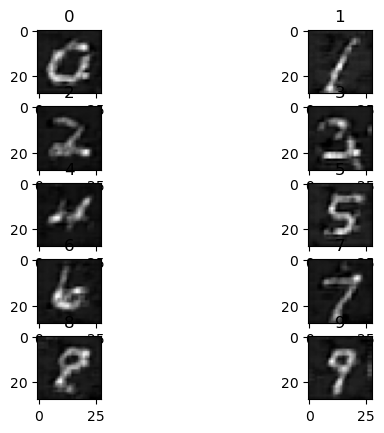

1/1 [==============================] - 0s 44ms/step
EPOCH ===  280
Generator loss =  [0.08268146216869354, 1.0]
Discriminator_loss =  0.0009969808161258698
1/1 [==============================] - 0s 26ms/step


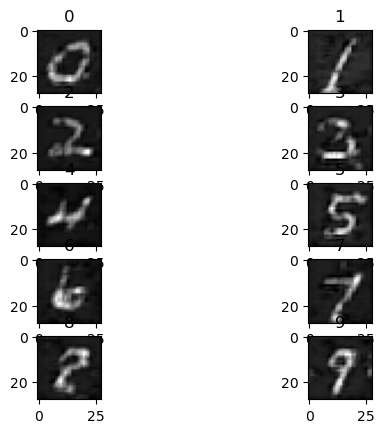

1/1 [==============================] - 0s 37ms/step
EPOCH ===  290
Generator loss =  [0.06019959598779678, 1.0]
Discriminator_loss =  0.007175127509981394
1/1 [==============================] - 0s 91ms/step


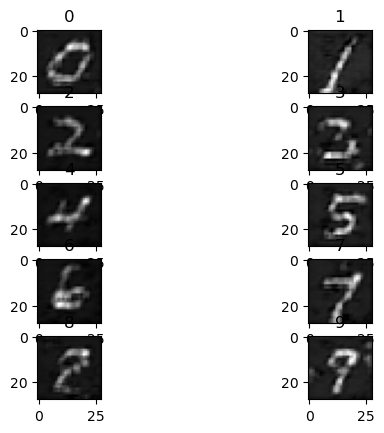

1/1 [==============================] - 0s 35ms/step
EPOCH ===  300
Generator loss =  [0.23711079359054565, 1.0]
Discriminator_loss =  0.001975548453629017
1/1 [==============================] - 0s 25ms/step


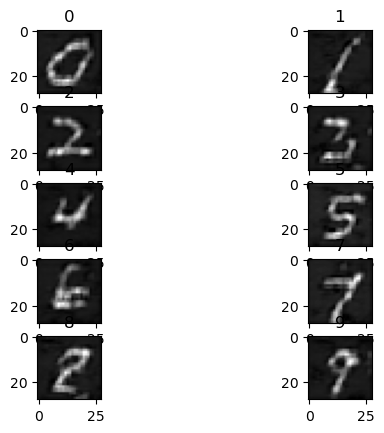

1/1 [==============================] - 0s 39ms/step
EPOCH ===  310
Generator loss =  [0.15604045987129211, 1.0]
Discriminator_loss =  0.004613587167114019
1/1 [==============================] - 0s 30ms/step


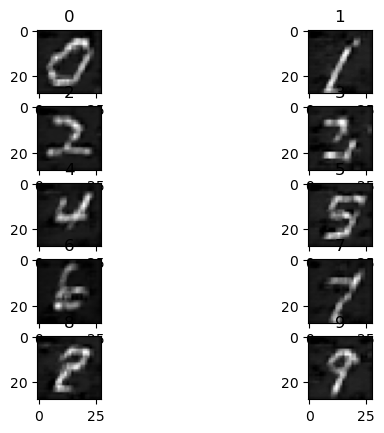

1/1 [==============================] - 0s 47ms/step
EPOCH ===  320
Generator loss =  [0.04821273684501648, 1.0]
Discriminator_loss =  0.006884905509650707
1/1 [==============================] - 0s 33ms/step


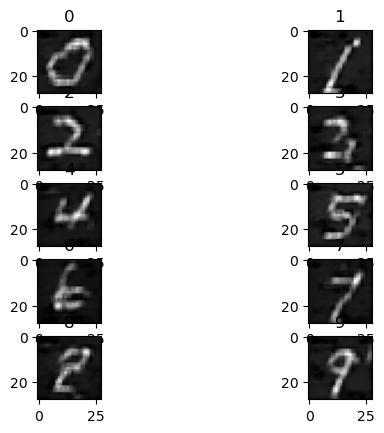

1/1 [==============================] - 0s 49ms/step
EPOCH ===  330
Generator loss =  [0.07207079231739044, 1.0]
Discriminator_loss =  7.125758565962315e-05
1/1 [==============================] - 0s 32ms/step


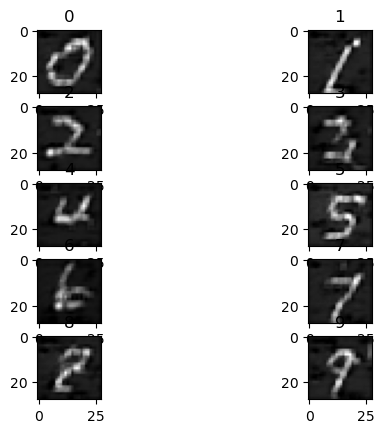

1/1 [==============================] - 0s 40ms/step
EPOCH ===  340
Generator loss =  [0.023372754454612732, 1.0]
Discriminator_loss =  0.0019212590996176004
1/1 [==============================] - 0s 25ms/step


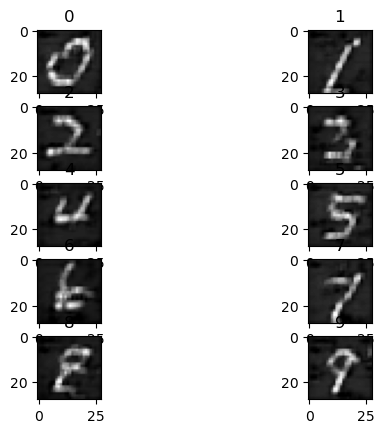

1/1 [==============================] - 0s 35ms/step
EPOCH ===  350
Generator loss =  [0.6666999459266663, 1.0]
Discriminator_loss =  0.00013069888518657535
1/1 [==============================] - 0s 24ms/step


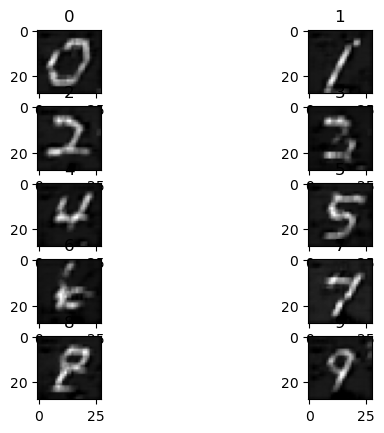

1/1 [==============================] - 0s 38ms/step
EPOCH ===  360
Generator loss =  [0.04146907478570938, 1.0]
Discriminator_loss =  0.0006426492473110557
1/1 [==============================] - 0s 25ms/step


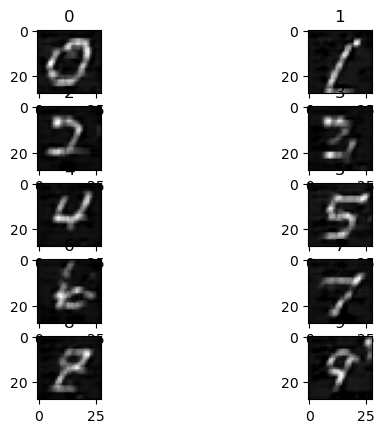

1/1 [==============================] - 0s 31ms/step
EPOCH ===  370
Generator loss =  [0.06493455916643143, 1.0]
Discriminator_loss =  0.00024989870144054294
1/1 [==============================] - 0s 24ms/step


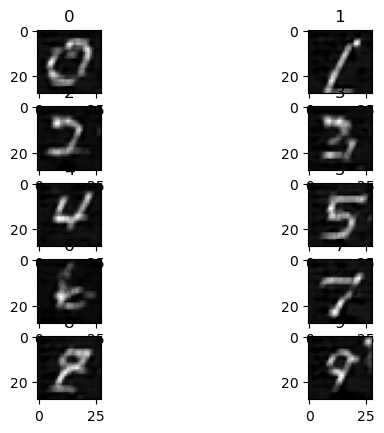

1/1 [==============================] - 0s 42ms/step
EPOCH ===  380
Generator loss =  [0.612335205078125, 1.0]
Discriminator_loss =  5.0141115934820846e-06
1/1 [==============================] - 0s 36ms/step


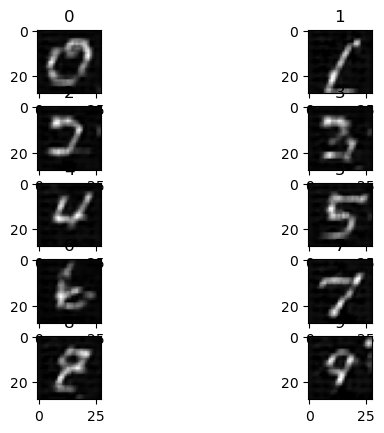

1/1 [==============================] - 0s 41ms/step
EPOCH ===  390
Generator loss =  [0.2126743346452713, 1.0]
Discriminator_loss =  0.014703886583447456
1/1 [==============================] - 0s 24ms/step


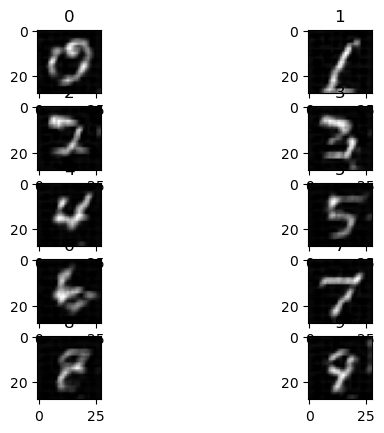

1/1 [==============================] - 0s 42ms/step
EPOCH ===  400
Generator loss =  [0.04104335606098175, 1.0]
Discriminator_loss =  7.877004100009799e-05
1/1 [==============================] - 0s 25ms/step


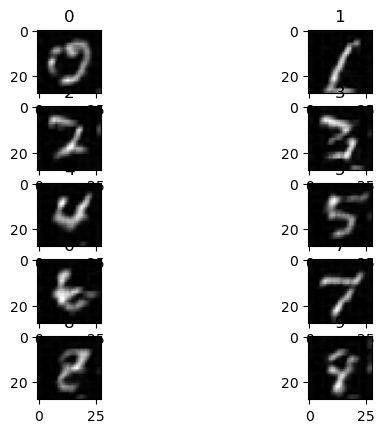

1/1 [==============================] - 0s 40ms/step
EPOCH ===  410
Generator loss =  [0.07549448311328888, 1.0]
Discriminator_loss =  8.200997399399057e-06
1/1 [==============================] - 0s 23ms/step


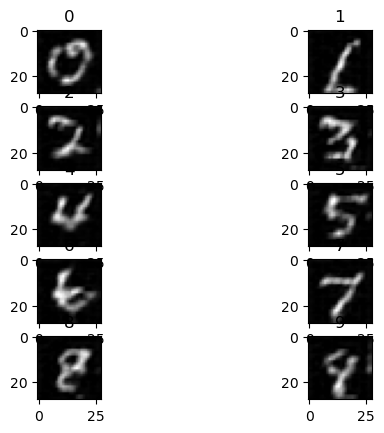

1/1 [==============================] - 0s 35ms/step
EPOCH ===  420
Generator loss =  [0.4552770256996155, 1.0]
Discriminator_loss =  8.019517281354638e-07
1/1 [==============================] - 0s 28ms/step


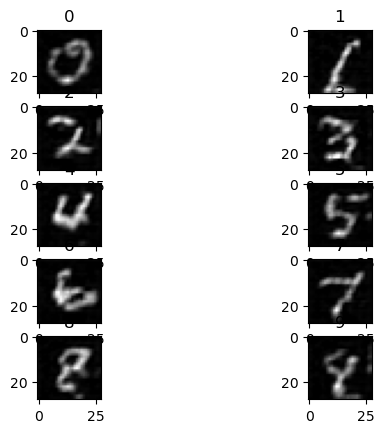

1/1 [==============================] - 0s 36ms/step
EPOCH ===  430
Generator loss =  [0.20473484694957733, 1.0]
Discriminator_loss =  0.00015778557281009853
1/1 [==============================] - 0s 38ms/step


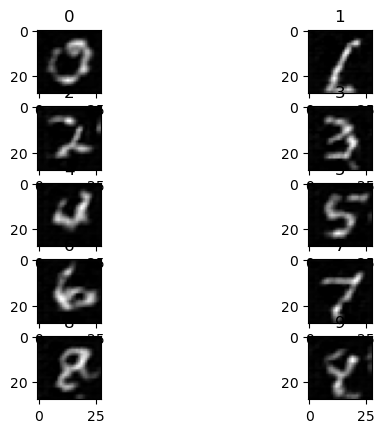

1/1 [==============================] - 0s 38ms/step
EPOCH ===  440
Generator loss =  [0.021190166473388672, 1.0]
Discriminator_loss =  0.00023838285414967686
1/1 [==============================] - 0s 32ms/step


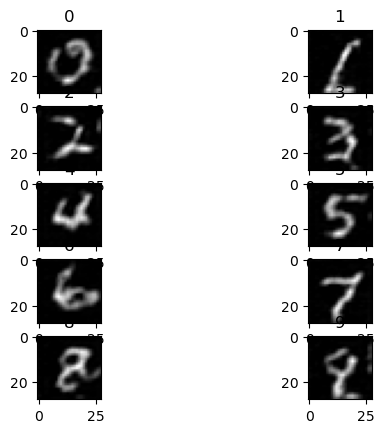

1/1 [==============================] - 0s 32ms/step
EPOCH ===  450
Generator loss =  [0.029025163501501083, 1.0]
Discriminator_loss =  0.000769897538702935
1/1 [==============================] - 0s 24ms/step


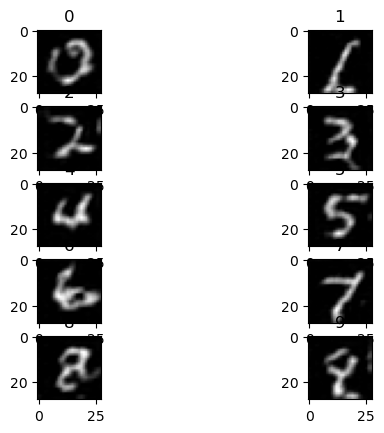

1/1 [==============================] - 0s 41ms/step
EPOCH ===  460
Generator loss =  [0.04171895608305931, 1.0]
Discriminator_loss =  0.00014440433005802333
1/1 [==============================] - 0s 24ms/step


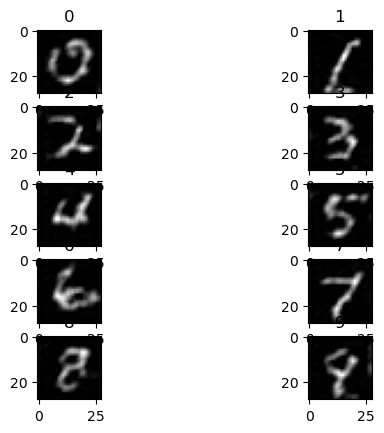

1/1 [==============================] - 0s 45ms/step
EPOCH ===  470
Generator loss =  [0.7203021049499512, 1.0]
Discriminator_loss =  0.03904183208942413
1/1 [==============================] - 0s 26ms/step


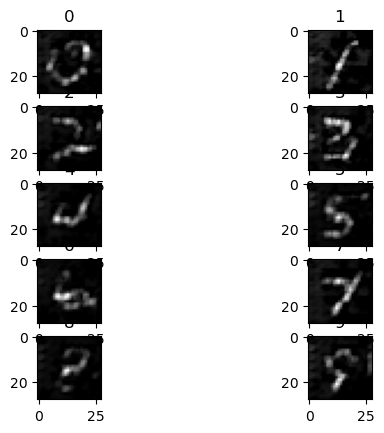

1/1 [==============================] - 0s 36ms/step
EPOCH ===  480
Generator loss =  [0.42334121465682983, 1.0]
Discriminator_loss =  0.07066822797060013
1/1 [==============================] - 0s 28ms/step


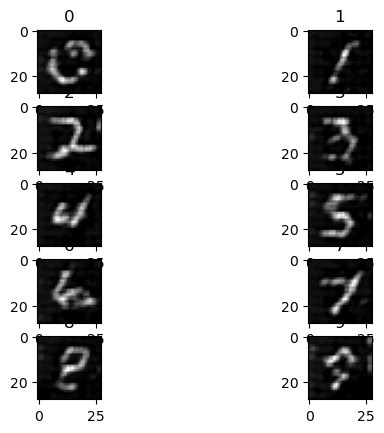

1/1 [==============================] - 0s 36ms/step
EPOCH ===  490
Generator loss =  [0.34847861528396606, 1.0]
Discriminator_loss =  0.00039615266723558307
1/1 [==============================] - 0s 24ms/step


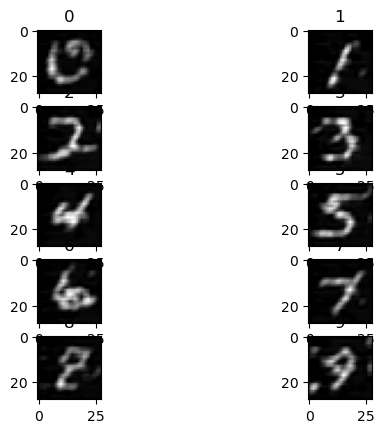

1/1 [==============================] - 0s 33ms/step
EPOCH ===  500
Generator loss =  [1.26993727684021, 1.0]
Discriminator_loss =  9.383588350786454e-10
1/1 [==============================] - 0s 24ms/step


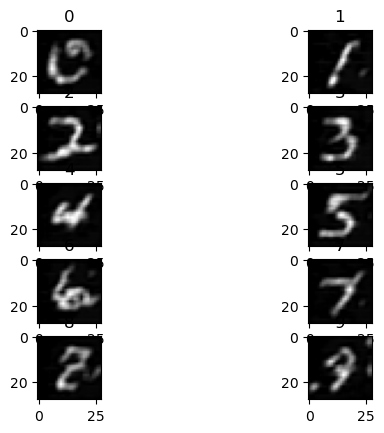

1/1 [==============================] - 0s 39ms/step
EPOCH ===  510
Generator loss =  [0.079642653465271, 1.0]
Discriminator_loss =  0.00024609052343294024
1/1 [==============================] - 0s 61ms/step


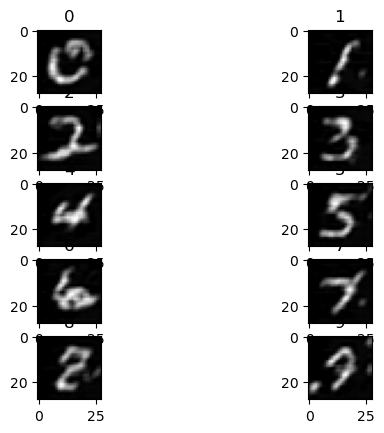

1/1 [==============================] - 0s 52ms/step
EPOCH ===  520
Generator loss =  [0.009332271292805672, 1.0]
Discriminator_loss =  0.002220727736130357
1/1 [==============================] - 0s 34ms/step


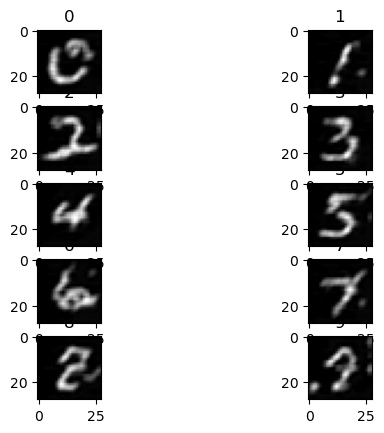

1/1 [==============================] - 0s 46ms/step


KeyboardInterrupt: 

In [35]:
num_epochs = 1000
batch_size = 32

valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))
display_interval = 10
for epoch in range(num_epochs):

    discm_loss_real = 0
    discm_loss_fake = 0
    genr_loss = 0

    # On choisit aléatoirement des données

    # On entraine sur le vrai dataset


    index = np.random.randint(0, x_train.shape[0], batch_size)
    images = x_train[index]
    label_images = y_train[index]
    transformed_label_images = vectorization(label_images)
    # On entraine sur des données générées
    random_y = np.random.randint(0, 10, batch_size)
    random_y = vectorization(random_y)

    noise = np.random.normal(0, 1, (batch_size, input_vector_size))
    #On génère une image aléatoire, avec une classe aléatoirement choisie
    discm_loss_real = discriminator.train_on_batch([transformed_label_images, images], valid)

    data = []
    for item in label_images:
        random_number = np.random.randint(0,8)
        if random_number == item:
            data.append(9)
        else:
            data.append(random_number)

    data=np.array(data)
    wrong_label = vectorization(data)
    discm_loss = discriminator.train_on_batch([wrong_label, images], fake)

    for i in range(3):
        noise = np.random.normal(0, 1, (batch_size, input_vector_size))
        generated_images = generator.predict([random_y, noise])
        discm_loss_fake = discriminator.train_on_batch([random_y, generated_images], fake)

    for i in range(5):
        random_y = np.random.randint(0, 10, batch_size)
        random_y = vectorization(random_y)
        noise = np.random.normal(0, 1, (batch_size, input_vector_size))
        genr_loss = combined_network.train_on_batch([random_y, noise], valid)

    if epoch % display_interval == 0:
        print("EPOCH === ", epoch)
        print('Generator loss = ', genr_loss)
        print('Discriminator_loss = ', discm_loss_fake)
        display_images()

1/1 [==============================] - 0s 23ms/step


(-0.5, 27.5, 27.5, -0.5)

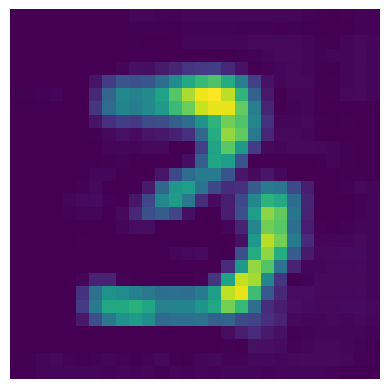

In [54]:
 noise = np.random.normal(0, 1, (1, input_vector_size))
image = generator.predict([
    vectorization(np.array([3])),
    noise
])

plt.imshow(image[0, :, :, ])
plt.axis('off')